In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, RandomRotation, RandomFlip, RandomContrast, Rescaling, Input, Activation
import matplotlib.pyplot as plt
import logging
tf.get_logger().setLevel(logging.ERROR)
keras.utils.set_random_seed(17)

In [2]:
cs_class_net = keras.models.load_model('csbin_model_v2_without_aug.keras')

In [3]:
lyrs = cs_class_net.layers
nl = len(lyrs)

In [4]:
# Путь к данным

# Каталог с набором данных
data_dir = 'data/dataset_ak_awp/all_pics'
# Каталог с данными для обучения
train_dir = 'data/dataset_ak_awp/train_r_tr'
# Каталог с данными для проверки
val_dir = 'data/dataset_ak_awp/val_r_tr'
# Каталог с данными для тестирования
test_dir = 'data/dataset_ak_awp/test_r_tr'

# train_dir = 'data/newdata/train_rndm'
# test_dir = 'data/newdata/test_rndm'
# val_dir = 'data/newdata/val_rndm'

lm = 'binary'

In [5]:
img_h = 512
img_w = 512
size = (img_h, img_h)

In [6]:
input_shape = (img_h, img_w, 3)

In [7]:
train = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode=lm, image_size=size)

validate = keras.utils.image_dataset_from_directory(
    directory=val_dir,
    labels='inferred',
    label_mode=lm, image_size=size)

test = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode=lm, image_size=size)

Found 540 files belonging to 2 classes.
Found 180 files belonging to 2 classes.
Found 180 files belonging to 2 classes.


In [8]:
EPOCHS = 500
#BATCH_SIZE = 64
BATCH_SIZE = 900

data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(factor=0.1),
        tf.keras.layers.RandomContrast(factor=0.1),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        tf.keras.layers.RandomBrightness(factor=0.2)
    ]
)

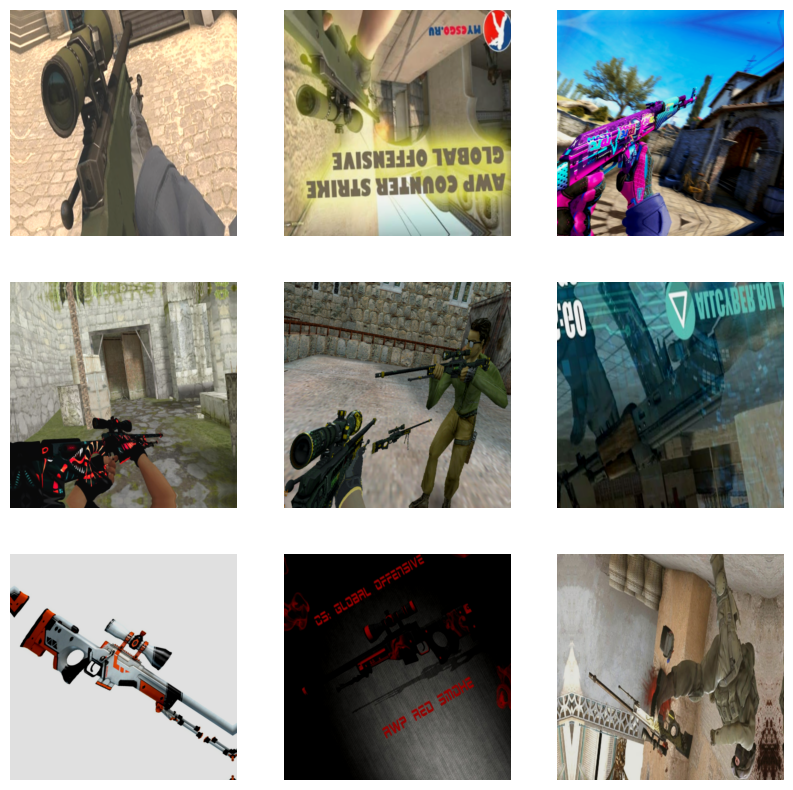

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[i].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [10]:
'''
Определение модели на основе трансферного обучения
'''

pretrained = Sequential([
    cs_class_net.get_layer(index=0),
    cs_class_net.get_layer(index=1),
    cs_class_net.get_layer(index=2),
    cs_class_net.get_layer(index=3),
    cs_class_net.get_layer(index=4),
    cs_class_net.get_layer(index=5),
    cs_class_net.get_layer(index=6),
    cs_class_net.get_layer(index=7),
    cs_class_net.get_layer(index=8),
    cs_class_net.get_layer(index=9),
    cs_class_net.get_layer(index=10),
    cs_class_net.get_layer(index=11),
    cs_class_net.get_layer(index=12),
    cs_class_net.get_layer(index=13)
])
# "фризим" тренированную модель
pretrained.trainable = False
pretrained.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,106,017 (4.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,106,017 (4.22 MB)

In [11]:
# создаем входной слой новой модели
inputs = keras.Input(shape=input_shape)
# этот слой поменяет формат данных на пригодный для моей тренированной модели
rescale = MaxPooling2D((4, 4), strides=4)

# прогоняем через новые данные
#x = rescale(data_augmentation(inputs))
x = rescale(inputs)
#x = inputs
x = pretrained(x, training=False)

# слой новой модели который обмышляет полученные от тренированной модели данные и проводит классификацию
output = Dense(1, activation="sigmoid")(x)
# окончательно формируем новую модель(по сути новая модель - просто подгонка данных под старую)
# единственным новым обучаемым слоем является слой классификации
# таким образом я создал новую сеть приспособленную к новым данным на основе старой
model = keras.Model(inputs, output)

In [12]:
model.compile(loss=f'{lm}_crossentropy',
              optimizer='adam', metrics =['accuracy'])

# Вывод сведений о слоях модели
model.summary()
# Компиляция модели

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │     1,106,017 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,106,019 (4.22 MB)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 1,106,017 (4.22 MB)

In [13]:
history = model.fit(train, validation_data=validate,
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    #verbose=2,
                    shuffle=True)

Epoch 1/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.3211 - loss: 0.8023 - val_accuracy: 0.2389 - val_loss: 0.7921
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.1829 - loss: 0.8051 - val_accuracy: 0.2222 - val_loss: 0.7858
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.1932 - loss: 0.7942 - val_accuracy: 0.2167 - val_loss: 0.7858
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.1555 - loss: 0.7947 - val_accuracy: 0.2111 - val_loss: 0.7796
Epoch 5/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.1585 - loss: 0.7791 - val_accuracy: 0.2111 - val_loss: 0.7757
Epoch 6/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.1769 - loss: 0.7759 - val_accuracy: 0.2111 - val_loss: 0.7710
Epoch 7/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.1437 - loss: 0.7818 - val_accuracy: 0.2056 - val_loss: 0.7679
Epoch 8/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.1810 - loss: 0.7674 - val_accu

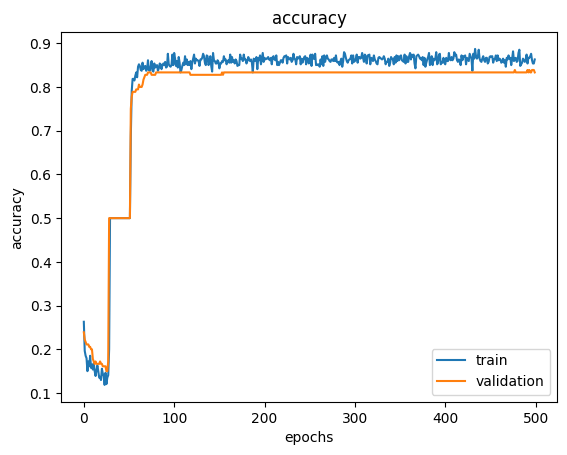

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
#plt.xlim([0, 100])

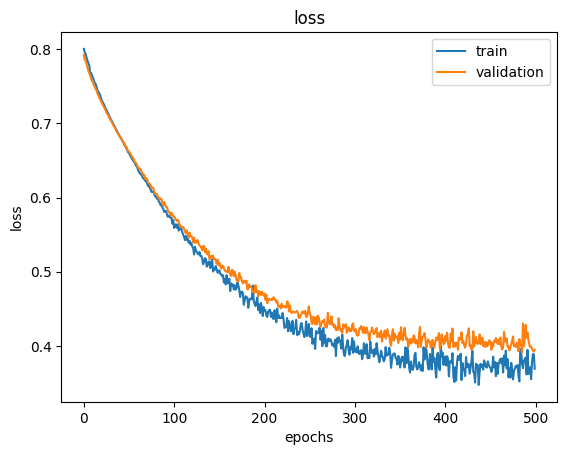

In [21]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
#plt.xlim([0, 100])

In [16]:
model.evaluate(validate)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8198 - loss: 0.4348


[0.40307894349098206, 0.8333333134651184]

In [17]:
model.evaluate(test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8819 - loss: 0.3405


[0.3658125698566437, 0.8666666746139526]

In [26]:
img, labels = list(test)[0]
x_out = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


90.0 %


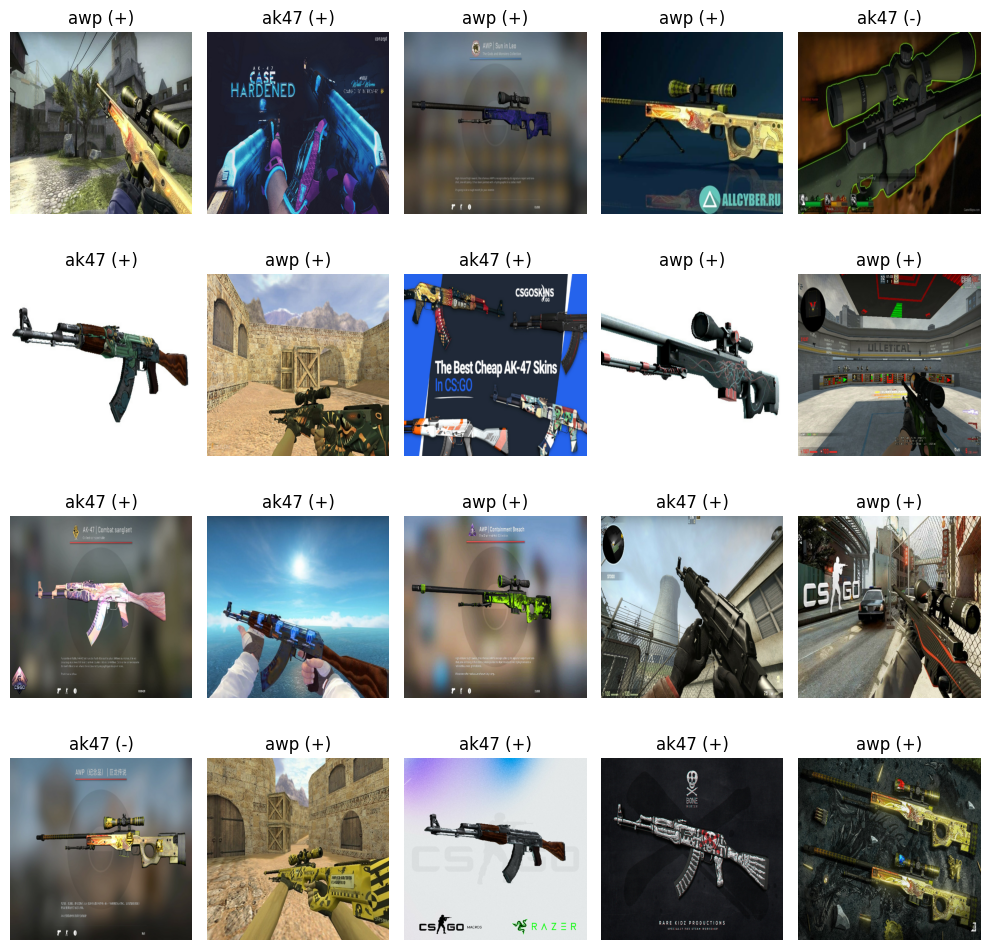

In [27]:
# Display the results
c = 0
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for i in range(20):
    if x_out[i] >= 0.5 and labels[i] == 1 or x_out[i] < 0.5 and labels[i] == 0:
        sign = '+'
        c += 1
    else: sign = '-'
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    ax.imshow(img[i].numpy().astype("uint8"))
    ax.axis("off")
    ax.set_title(f"{'ak47' if x_out[i] <= 0.5 else 'awp'} ({sign})", fontsize=12)
plt.tight_layout()
print(c/20*100, '%')